<a href="https://colab.research.google.com/github/AlexGrig/practical-rl/blob/master/sem-1-crossentropy-method-gym-intro/sem-1-crossentropy-method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crossentropy method

This notebook will teach you to solve reinforcement learning problems with crossentropy method. We'll follow-up by scaling everything up and using neural network policy.

In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Selecting previously unselected package xvfb.
(Reading database ... 155676 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.11_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.11) ...
Setting up xvfb (2:1.19.6-1ubuntu4.11) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Starting virtual X frame buffer: Xvfb.


In [2]:
!pip install gym[toy_text]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.3 MB 40 kB/s 


In [3]:
import gym
import numpy as np
import pandas as pd

env = gym.make("Taxi-v3", new_step_api=True, render_mode='ansi')
env.reset()
print(env.render()[0])

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




In [4]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i" % (n_states, n_actions))

n_states=500, n_actions=6


In [5]:
4 * 4 * 25 + 4 * 25

500

In [6]:
env.observation_space, env.action_space

(Discrete(500), Discrete(6))

# Create stochastic policy

This time our policy should be a probability distribution.

```policy[s,a] = P(take action a | in state s)```

Since we still use integer state and action representations, you can use a 2-dimensional array to represent the policy.

Please initialize policy __uniformly__, that is, probabililities of all actions should be equal.


In [7]:
policy = 1./n_actions * np.ones((500,6))

In [8]:
assert type(policy) in (np.ndarray, np.matrix)
assert np.allclose(policy, 1./n_actions)
assert np.allclose(np.sum(policy, axis=1), 1)

# Play the game

Just like before, but we also record all states and actions we took.

In [9]:
env.reset()
tt = env.step(3)
tt

(209,
 -1,
 False,
 False,
 {'prob': 1.0, 'action_mask': array([1, 1, 1, 0, 0, 0], dtype=int8)})

In [10]:
len(tt)

5

In [11]:
policy[6,:]

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667])

In [12]:
def generate_session(policy, t_max=10**4, render=False, test=False):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states, n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states, actions = [], []
    total_reward = 0.

    n_states, n_actions = policy.shape

    s = env.reset()

    for t in range(t_max):
                
        # use the probabilities you predicted to pick an action
        if test:
            # on the test use the best (the most likely) actions at test
            # experiment, will it work on the train and vice versa?
            a = np.argmax( policy[s,:] )
            # ^-- hint: try np.argmax
        else:
            # sample proportionally to the probabilities,
            # don't just take the most likely action at train
            a = np.random.choice(np.arange(0, n_actions), p=policy[s,:] )
            # ^-- hint: try np.random.choice

        new_s, r, done, trunc, info = env.step(a)
        
        if render:
            print(env.render()[0])

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
            
    if render:
        env.close()
            
    return states, actions, total_reward

In [13]:
s, a, r = generate_session(policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float, np.float]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


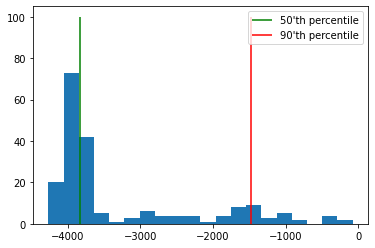

In [14]:
# let's see the initial reward distribution
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session(policy, t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards, bins=20)
plt.vlines([np.percentile(sample_rewards, 50)], [0], [100], label="50'th percentile", color='green')
plt.vlines([np.percentile(sample_rewards, 90)], [0], [100], label="90'th percentile", color='red')
plt.legend()

### Crossentropy method steps (2pts)

In [15]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """
    
    
    if percentile == 0:
      elite_states = [vv for ll in states_batch for vv in ll] # flatten
      elite_actions = [vv for ll in actions_batch for vv in ll] # flatten 
    else:
      perc = np.percentile(rewards_batch, percentile)
      inds = np.nonzero(rewards_batch >= perc)[0]
      
      elite_states = [vv for ii in inds for vv in states_batch[ii]]
      elite_actions = [vv for ii in inds for vv in actions_batch[ii]]

    return elite_states, elite_actions

In [16]:
states_batch = [
    [1, 2, 3],     # game1
    [4, 2, 0, 2],  # game2
    [3, 1],        # game3
]

actions_batch = [
    [0, 2, 4],     # game1
    [3, 2, 0, 1],  # game2
    [3, 3],        # game3
]
rewards_batch = [
    3,  # game1
    4,  # game2
    5,  # game3
]

test_result_0 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=0)
test_result_40 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=30)
test_result_90 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=90)
test_result_100 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=100)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1])  \
    and np.all(test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]),\
    "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_40[0] == [4, 2, 0, 2, 3, 1]) and \
    np.all(test_result_40[1] == [3, 2, 0, 1, 3, 3]),\
    "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3, 1]) and \
    np.all(test_result_90[1] == [3, 3]),\
    "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3, 1]) and\
    np.all(test_result_100[1] == [3, 3]),\
    "Please make sure you use >=, not >. Also double-check how you compute percentile."
print("Ok!")

Ok!


In [17]:
def update_policy(elite_states, elite_actions):
    """
    Given old policy and a list of elite states/actions from select_elites,
    return new updated policy where each action probability is proportional to

    policy[s_i,a_i] ~ #[occurences of si and ai in elite states/actions]

    Don't forget to normalize policy to get valid probabilities and handle 0/0 case.
    In case you never visited a state, set probabilities for all actions to 1./n_actions

    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions

    """

    #new_policy = np.ones([n_states, n_actions]) # this adds smoothing. At least one observation for each action.
    new_policy = np.zeros([n_states, n_actions])
    
    np.add.at(new_policy, (elite_states, elite_actions), 1 )

    # not visited states get uniform distribution
    mask = ~np.any(new_policy, axis=1)
    new_policy[mask] = 1

    # normalize new policy
    norm_term = new_policy.sum(axis=1)[:,np.newaxis]
    norm_term = np.repeat(norm_term, n_actions, axis=1)

    new_policy = new_policy / norm_term
    #<Your code here: update probabilities for actions given elite states & actions >
    # Don't forget to set 1/n_actions for all actions in unvisited states.

    return new_policy

In [18]:
tt = np.ones([5, 2]).sum(axis=1)[:,np.newaxis]
tt = np.repeat(tt, 3, axis=1)
tt

array([[2., 2., 2.],
       [2., 2., 2.],
       [2., 2., 2.],
       [2., 2., 2.],
       [2., 2., 2.]])

In [19]:
aa= np.array([1,2,3])[:,np.newaxis]
np.repeat(aa, 3, axis=1)

array([[1, 1, 1],
       [2, 2, 2],
       [3, 3, 3]])

In [20]:
elite_states = [1, 2, 3, 4, 2, 0, 2, 3, 1]
elite_actions = [0, 2, 4, 3, 2, 0, 1, 3, 3]

new_policy = update_policy(elite_states, elite_actions)
print(new_policy[:4, :5])
assert np.isfinite(new_policy).all(
), "Your new policy contains NaNs or +-inf. Make sure you don't divide by zero."
assert np.all(
    new_policy >= 0), "Your new policy can't have negative action probabilities"
assert np.allclose(new_policy.sum(
    axis=-1), 1), "Your new policy should be a valid probability distribution over actions"

reference_answer = np.array([
    [1.,  0.,  0.,  0.,  0.],
    [0.5,  0.,  0.,  0.5,  0.],
    [0.,  0.33333333,  0.66666667,  0.,  0.],
    [0.,  0.,  0.,  0.5,  0.5]])
assert np.allclose(new_policy[:4, :5], reference_answer)
print("Ok!")

[[1.         0.         0.         0.         0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.33333333 0.66666667 0.         0.        ]
 [0.         0.         0.         0.5        0.5       ]]
Ok!


# Training loop
Generate sessions, select N best and fit to those.

In [21]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()
    
    clear_output(True)
    plt.show()

In [22]:
arr = ['sunday', 'monday', 'tuesday', 'wednesday']
[tt for tt in zip(*arr)]

[('s', 'm', 't', 'w'),
 ('u', 'o', 'u', 'e'),
 ('n', 'n', 'e', 'd'),
 ('d', 'd', 's', 'n'),
 ('a', 'a', 'd', 'e'),
 ('y', 'y', 'a', 's')]

In [26]:
# reset policy just in case
policy = np.ones([n_states, n_actions]) / n_actions

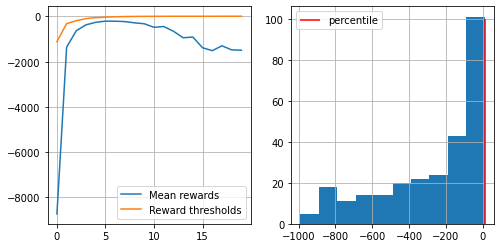

In [27]:
n_sessions = 500  # sample this many sessions
percentile = 50  # take this percent of session with highest rewards. 
learning_rate = 0.5  # add this thing to all counts for stability
epochs = 20

log = []

for i in range(epochs):

    sessions =    [generate_session(policy, t_max=10**4, render=False, test=False) for _ in range(0, n_sessions)] #[ < generate a list of n_sessions new sessions > ]
    states_batch, actions_batch, rewards_batch = zip(*sessions)
    
    elite_states, elite_actions = select_elites(states_batch,
                    actions_batch, rewards_batch, percentile) #< select elite states/actions >
    
    new_policy = update_policy(elite_states, elite_actions)
    policy = (1 - learning_rate)*policy + learning_rate*new_policy

    # display results on chart
    show_progress(rewards_batch, log, percentile)

In [ ]:
sessions[0]

([31, 31, 31, 131, 231, 211, 311, 411, 419, 319, 219, 239, 259, 279, 379, 479],
 [2, 2, 0, 0, 3, 0, 0, 4, 1, 1, 2, 2, 2, 0, 0, 5],
 5.0)

In [ ]:
generate_session(policy, render=True);

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| 

### Reflecting on results

You may have noticed that the taxi problem quickly converges from <-1000 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

In case CEM failed to learn how to win from one distinct starting point, it will simply discard it because no sessions from that starting point will make it into the "elites".

To mitigate that problem, you can either reduce the threshold for elite sessions (duct tape way) or  change the way you evaluate strategy (theoretically correct way). You can first sample an action for every possible state and then evaluate this choice of actions by running _several_ games and averaging rewards.